# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [7]:
from src.music_transformer import *

In [8]:
from src.unilm import *

In [9]:
config = unilm_config(vocab)
cache_name = 'tmp/hook_c'
base_path = Path('../../data/midi/v15/')

## BERT Dataloading

In [10]:
# ns_dl_tfms = [mask_tfm, next_sentence_tfm]
# ns_config = config.copy()
# ns_config['bs'] *= 2
# ns_data = load_music_data(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
#                           y_offset=0, dl_tfms=ns_dl_tfms, **ns_config)

# s2s_dl_tfms = [s2s_tfm]
# s2s_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
#                            preloader_cls=S2SPreloader, dl_tfms=s2s_dl_tfms, y_offset=1,
#                            shuffle_dl=True, **config)

# nw_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, 
#                               vocab=vocab, dl_tfms=[nw_tfm], y_offset=1, 
#                               train_tfms=[to_single_stream], valid_tfms=[to_single_stream], **config)

## Seq2Seq Translation

In [42]:
csv_path = base_path/f'piano_duet/piano_duet.csv'
# csv_path = base_path/f's2s_encode/s2s_encode.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
# title_filter = df['title'].str.contains('across-the-universe')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,7,10,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,song_url,section,numpy,ht_mode,midi,title,ht_time_signature,mxl,ht_offset,ht_bpm,ht_key,md5,midi_title,artist,genres,parts,source
193179,https://www.hooktheory.com/theorytab/view/ritc...,chorus,piano_duet/hooktheory/pianoroll/r/ritchie-vale...,1.0,midi_sources/hooktheory/pianoroll/r/ritchie-va...,la-bamba,4.0,NaN,0.0,144.0,C,aeee134e4034e5f98bb630c56d2f7f8c,La Bamba,ritchie-valen,"Pop,Rock",chorus,hooktheory_c


In [43]:
idx = 0
file = base_path/results.numpy.values[idx];
orig = base_path/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [44]:
# seed_len = 40
# melody_np, chord_np = np.load(file, allow_pickle=True)

ValueError: too many values to unpack (expected 2)

In [27]:
def chordarr2npenc(chordarr):
    # combine instruments
    result = []
    wait_count = 0
    for idx,timestep in enumerate(chordarr):
        flat_time = timestep2npenc(timestep)
        if len(flat_time) == 0:
            wait_count += 1
        else:
            # pitch, octave, duration, instrument
            if wait_count > 0: result.append([VALTSEP, wait_count])
            result.extend(flat_time)
            wait_count = 1
    if wait_count > 0: result.append([VALTSEP, wait_count])
    return np.array(result, dtype=int)

# Note: not worrying about overlaps - as notes will still play. just look tied
# http://web.mit.edu/music21/doc/moduleReference/moduleStream.html#music21.stream.Stream.getOverlaps
def timestep2npenc(timestep, note_range=(0,128), enc_type=None):
    # inst x pitch
    notes = []
    for i,n in zip(*timestep.nonzero()):
        d = timestep[i,n]
        if d < 0: continue # only supporting short duration encoding for now
        if n < note_range[0] or n >= note_range[1]: continue # must be within midi range
        notes.append([n,d,i])
        
    notes = sorted(notes, key=lambda x: x[0], reverse=True) # sort by note (highest to lowest)
    
    if enc_type is None: 
        # note, duration
        return [n[:2] for n in notes] 
    if enc_type == 'parts':
        # note, duration, part
        return [n for n in notes]
    if enc_type == 'full':
        # note_class, duration, octave, instrument
        return [[n%12, d, n//12, i] for n,d,i in notes] 
    
def npenc2chordarr(npenc, note_range=128):
    max_vals = npenc.max(axis=0)
    num_instruments = 1 if len(npenc.shape) <= 2 else max_vals[-1]
    
    max_len = npenc_len(npenc)
    # score_arr = (steps, inst, note)
    score_arr = np.zeros((max_len, num_instruments, note_range))
    
    idx = 0
    for step in npenc:
        n,d,i = (step.tolist()+[0])[:3] # or n,d,i
        if n < VALTSEP: continue # special token
        if n == VALTSEP:
            idx += d
            continue
        score_arr[idx,i,n] = d
    return score_arr

def npenc_len(npenc):
    duration = 0
    for t in npenc:
        if t[0] == VALTSEP: duration += t[1]
    return duration

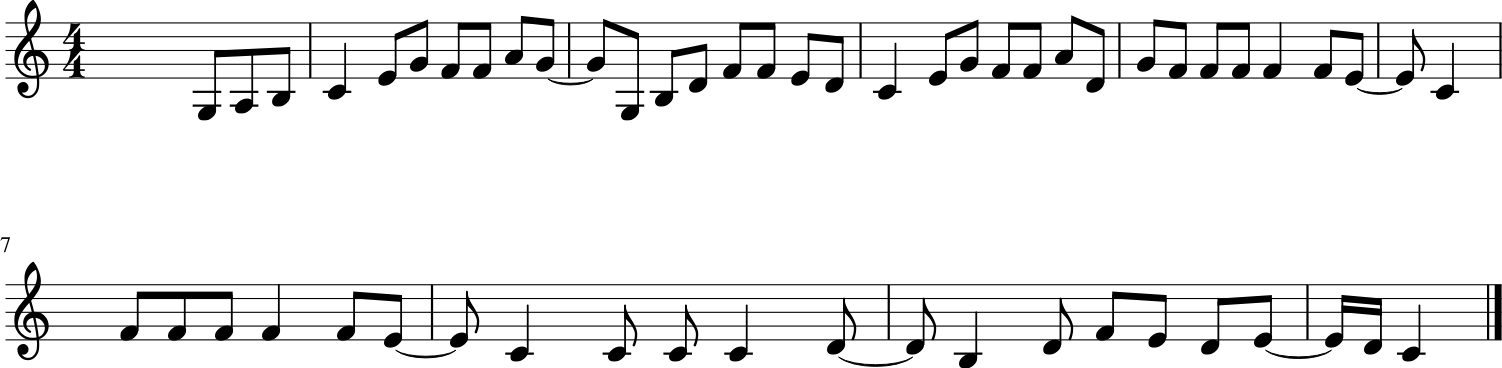

In [28]:
chordarr2stream(seq2chordarr(npenc2seq(melody_np))).show()

In [37]:

stream = file2stream(orig) # 1.
chordarr = stream2chordarr(stream) # 2.
npenc = chordarr2npenc(chordarr)

In [38]:
chordarr.shape

(153, 2, 128)

In [39]:
renc_chordarr = npenc2chordarr(npenc)

In [40]:
renc_chordarr.shape

(153, 1, 128)

In [34]:
npenc.shape

(161, 2)

In [30]:
npenc[:10]

array([[-1, 10],
       [55,  2],
       [-1,  2],
       [57,  2],
       [-1,  2],
       [59,  2],
       [-1,  2],
       [60,  4],
       [55,  8],
       [52,  8]])

## Original

In [47]:
stream = file2stream(orig) # 1.
s_arr = stream2chordarr(stream) # 2.
seq = chordarr2seq(s_arr) # 3.
npenc = seq2npenc(seq)

In [48]:
reenc_seq = npenc2seq(npenc)
reenc_chordarr = seq2chordarr(reenc_seq)

In [49]:
reenc_chordarr.shape

(147, 1, 128)

## Testing

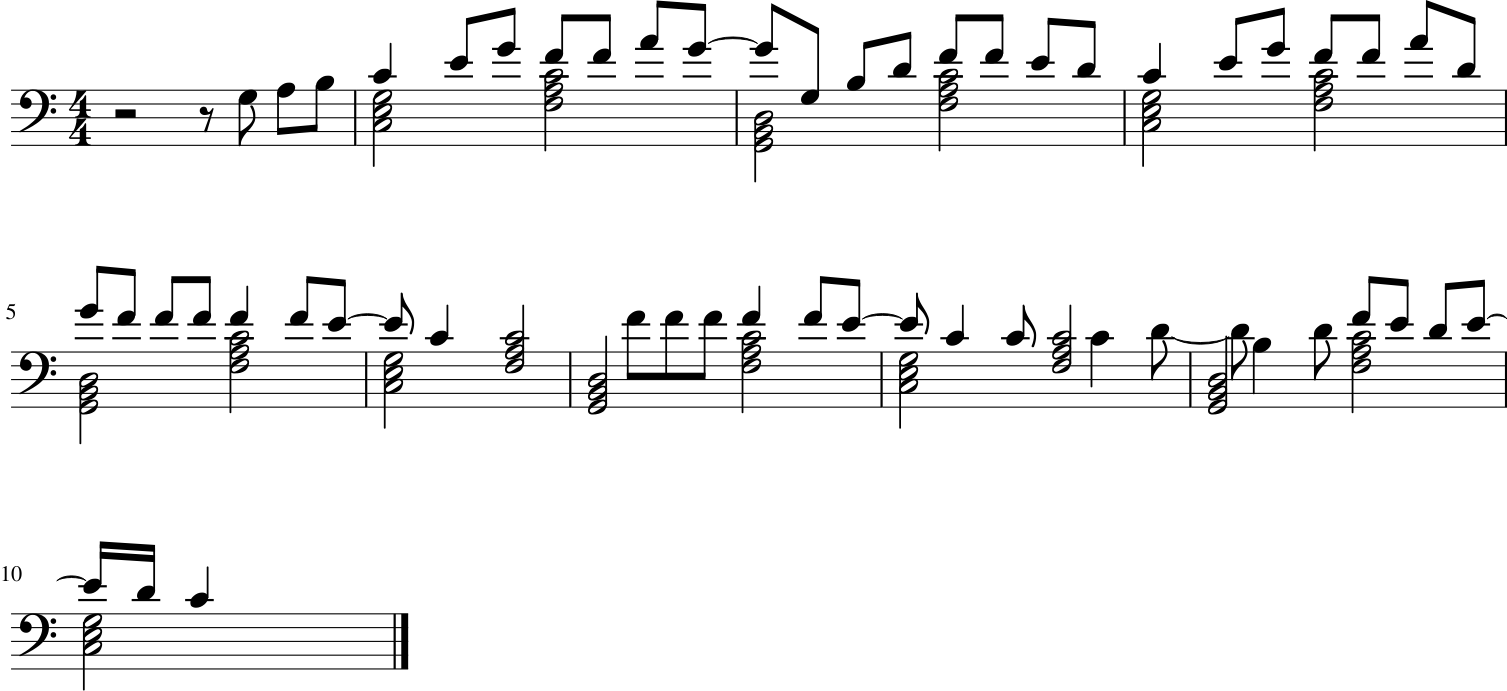

In [31]:
chordarr2stream(npenc2chordarr(npenc)).show()

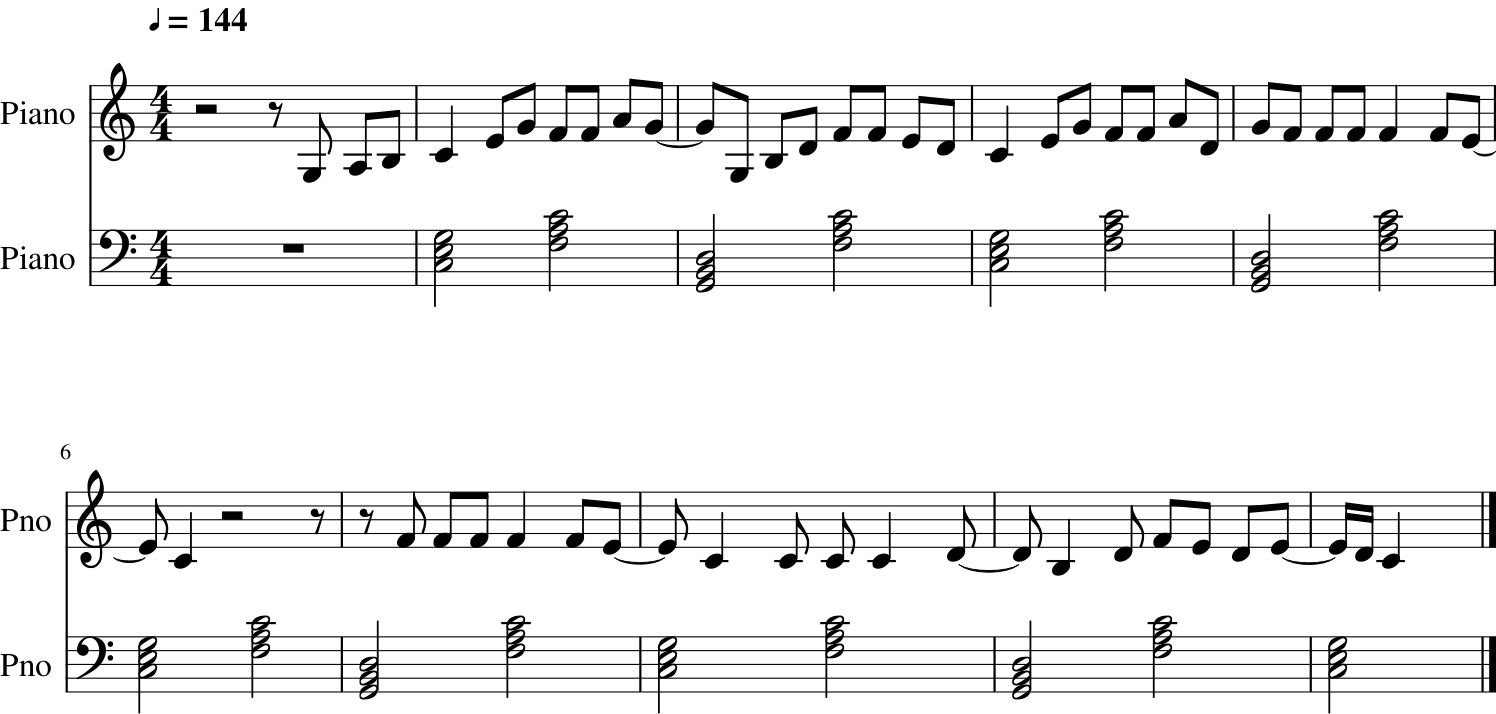

In [32]:
file2stream(orig).show()